In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

import re 
import nltk 

from sklearn.feature_extraction.text import CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.model_selection import train_test_split
from time import time

# from sklearn import svm
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier


#from google.colab import files
from matplotlib import pyplot as plt
import pandas as pd
import io
from sklearn.metrics import classification_report
import pickle

In [3]:
# uploading dataset
#uploaded = files.upload()

In [4]:
#dataframe manipulation
def performDataFrameManipulation():
  df = pd.read_csv(r"C:\Users\Arjun\Downloads\Compressed\CyberBullying-Detection-in-Hinglish-Languages-Using-Machine-Learning--main\Dataset\final_dataset_hinglish.csv")

  for index in df.index:
    if df.loc[index,"label"]==-1:
      df.loc[index,"label"]=1

  return df

df=performDataFrameManipulation()
df.head(6)

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1
5,tony sidaway is obviously a fist fuck ee he...,1


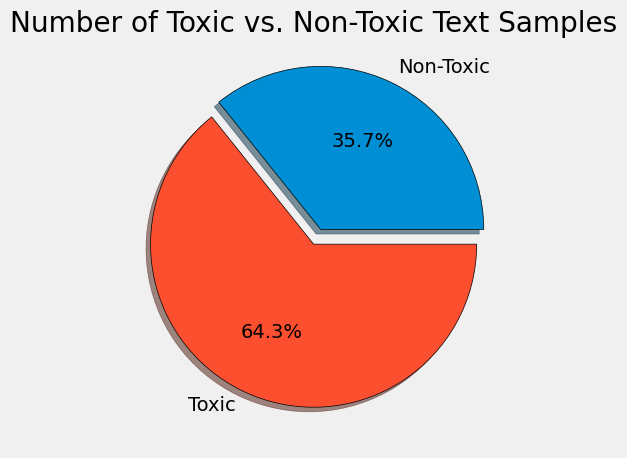

In [5]:
# Data classification using pie chart
def performDataDistribution(df):
  plt.style.use('fivethirtyeight')

  tot = df.shape[0]
  num_non_toxic = df[df.label==0].shape[0]
  slices = [num_non_toxic/tot,(tot - num_non_toxic)/tot]
  labeling = ['Non-Toxic','Toxic']
  explode = [0.1,0]
  plt.pie(slices,explode=explode,shadow=True,autopct='%1.1f%%',labels=labeling,wedgeprops={'edgecolor':'black'})
  plt.title('Number of Toxic vs. Non-Toxic Text Samples')
  plt.tight_layout()
  plt.show()

performDataDistribution(df)

In [6]:
#removing pattern
def remove_pattern(input_txt,pattern):
  if(type(input_txt)==str):
    r= re.findall(pattern,input_txt)
    for i in r:
      input_txt = re.sub(i,'',input_txt)
    return input_txt
  else:
    return ""

In [7]:
def performDataSetCleaning(df):
  df['headline'].dtype
 # calculate length of headline before cleaning
  df['length_headline'] = df['headline'].str.len()

  combi = pd.concat([df, df], ignore_index=True)

  # removes @user
  combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['headline'],"@[\w]*")
  # removes extra letters 
  combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-z#]"," ")
  # removes all those words with size less than 3 
  combi['tidy_tweet']= combi['tidy_tweet'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>3]))

# calculate length of headline after cleaning
  combi['length_tidy_tweet'] = combi['tidy_tweet'].str.len()

  # After cleaning the dataset i.e removal of hexadecimal pattern,hastags
  combi.head()

  # Applied Tokenization
  tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) #creates a list

  # Applied Lemmatization 
  nltk.download('wordnet')
  lemmatizer = nltk.stem.WordNetLemmatizer()
  tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

  for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
  combi['tidy_tweet'] = tokenized_tweet

  return combi,df

combi,df=performDataSetCleaning(df)  
combi.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,headline,label,length_headline,tidy_tweet,length_tidy_tweet
0,cock suck before you piss around on my work,1,44,cock suck before piss around work,33
1,you are gay or antisemmitian archangel white ...,1,624,antisemmitian archangel white tiger meow greet...,400
2,fuck your filthy mother in the ass dry,1,39,fuck your filthy mother,23
3,get fuck ed up get fuck ed up got a drink t...,1,121,fuck fuck drink that cant down fuck fuck fuck ...,51
4,stupid peace of shit stop deleting my stuff ...,1,93,stupid peace shit stop deleting stuff hole fal...,57


In [8]:
#Dataset splitting and applying feature extraction
def performTestDataSplitting(x,y,combi,df):
  X_train, X_test,y_train,y_test = train_test_split(combi['headline'], 
                                                    combi['label'], 
                                                    test_size=x,random_state=y)
  print('Number of rows in the total set: {}'.format(combi.shape[0]))
  print('Number of rows in the training set: {}'.format(X_train.shape[0]))
  print('Number of rows in the test set: {}'.format(X_test.shape[0]))


  # Instantiate the CountVectorizer method
  count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

  # Fit the training data and then return the matrix
  training_data = count_vector.fit_transform(X_train.values.astype('U'))
  print(X_train.shape)
  print(training_data.shape)

  # Transform testing data and return the matrix 
  testing_data = count_vector.transform(X_test.values.astype('U'))
  filename = 'vector_vocabulary.pkl'
  pickle.dump(count_vector.vocabulary_, open(filename, 'wb'))

  return X_train,X_test,y_train,y_test,testing_data,filename,training_data,count_vector

x_train,x_test,y_train,y_test,testing_data,filename,training_data,count_vector=performTestDataSplitting(0.33,42,combi,df)

Number of rows in the total set: 36296
Number of rows in the training set: 24318
Number of rows in the test set: 11978
(24318,)
(24318, 35417)


In [9]:
# Applying ML models
def pipeline(X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # make a list of models
    learner_list = [LinearSVC(),RandomForestClassifier(),LogisticRegression(),KNeighborsClassifier()]
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []

    for learner in learner_list:
        
        print(learner)
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # making pickle file here for my various classifier

        filename = learner.__class__.__name__+".pkl"
        pickle.dump(learner, open(filename, 'wb'))


        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

final_results=pipeline(training_data,y_train,testing_data,y_test)

LinearSVC()
Training LinearSVC


c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training LinearSVC finished in 0.46 sec
----------------------------------------------------
RandomForestClassifier()
Training RandomForestClassifier
Training RandomForestClassifier finished in 36.14 sec
----------------------------------------------------
LogisticRegression()
Training LogisticRegression


c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training LogisticRegression finished in 0.66 sec
----------------------------------------------------
KNeighborsClassifier()
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.00 sec
----------------------------------------------------


In [10]:
def performFinalResults(final_results):
  results = pd.DataFrame(final_results)
  results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

  results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

  return results

results=performFinalResults(final_results)
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,RandomForestClassifier,0.975538,0.983787,0.978032,0.980901,1.445690,0.999712,0.999872,0.999680,0.999776,36.144657
1,LinearSVC,0.972533,0.981181,0.975952,0.978560,0.002000,0.998561,0.998466,0.999296,0.998881,0.460711
2,LogisticRegression,0.962264,0.974322,0.966723,0.970508,0.002119,0.987088,0.989516,0.990402,0.989959,0.661819
3,KNeighborsClassifier,0.866839,0.915622,0.873131,0.893872,11.688440,0.918702,0.947137,0.925139,0.936009,0.002005


In [11]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.866839,0.915622,0.873131,0.893872,0.00200,0.918702,0.947137,0.925139,0.936009,0.002005
max,0.975538,0.983787,0.978032,0.980901,11.68844,0.999712,0.999872,0.999680,0.999776,36.144657


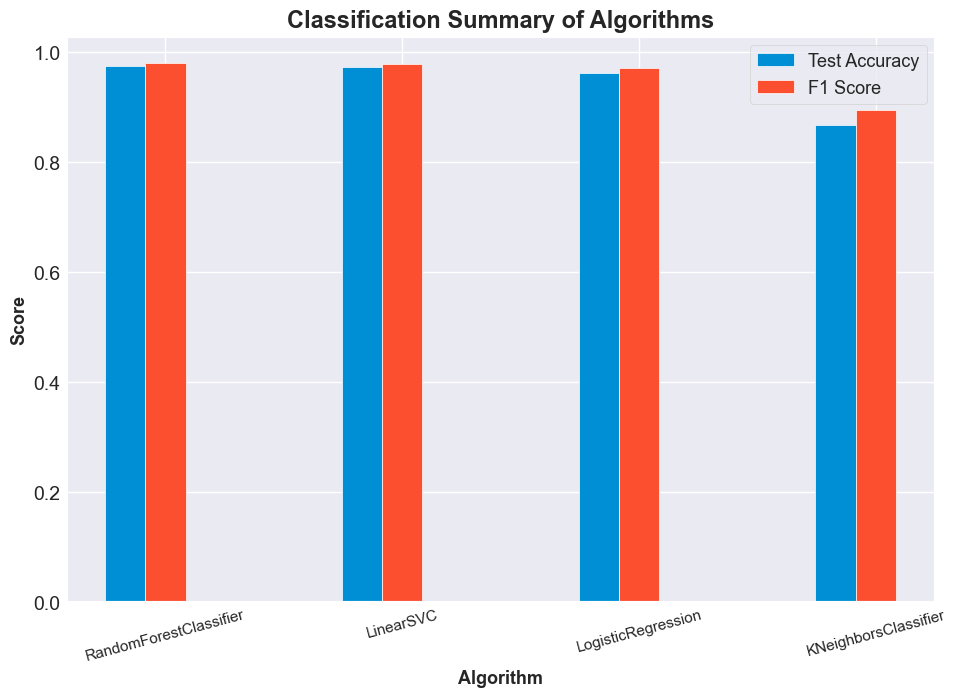

In [12]:
sns.set_style('darkgrid')
plt.figure(figsize = (10, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

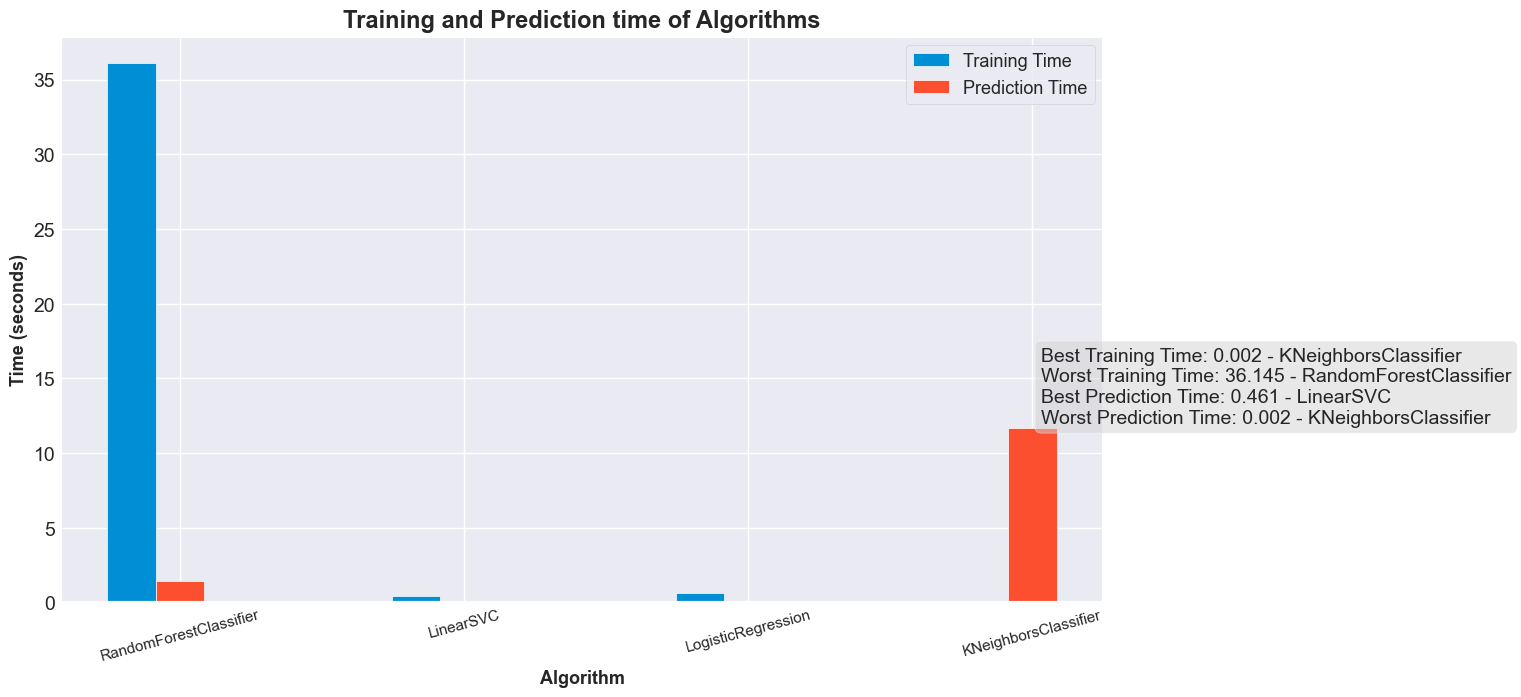

In [13]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [ ]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox

def has_cyberbullying(data):
  count_vector = CountVectorizer(stop_words= 'english', lowercase = True,vocabulary=pickle.load(open("vector_vocabulary.pkl", "rb")))
  data = [data]
  data = count_vector.fit_transform(data)

  trained_model=pickle.load(open(r"C:\Users\Arjun\Downloads\Compressed\CyberBullying-Detection-in-Hinglish-Languages-Using-Machine-Learning--main\Code\LinearSVC.pkl", 'rb'))
  print(trained_model.coef_.shape)

  print(trained_model.predict(data))
  if(trained_model.predict(data)==1):
    return True
  else:
    return False

def classify_text():
    user_text = text_input.get("1.0", tk.END).strip()
    if not user_text:
        messagebox.showinfo("Input Error", "Please enter some text to analyze.")
        return

    result = has_cyberbullying(user_text)
    if result:
        result_label.config(text="Cyberbullying Detected", foreground="red")
    else:
        result_label.config(text="Cyberbullying Not Detected", foreground="green")

root = tk.Tk()
root.title("Cyberbullying Detector")
root.geometry("400x300")
root.resizable(False, False)

style = ttk.Style(root)
style.theme_use("clam")
style.configure("TButton", font=("Helvetica", 12))
style.configure("TLabel", font=("Helvetica", 12))
style.configure("TFrame", background="#f0f0f0")

frame = ttk.Frame(root, padding="20 20 20 20", style="TFrame")
frame.pack(fill=tk.BOTH, expand=True)

title_label = ttk.Label(frame, text="Cyberbullying Detection", font=("Helvetica", 16, "bold"))
title_label.pack(pady=(0, 10))

text_input = tk.Text(frame, height=5, font=("Helvetica", 12))
text_input.pack(fill=tk.X, pady=10)

analyze_button = ttk.Button(frame, text="Analyze", command=classify_text)
analyze_button.pack(pady=(10, 5))

result_label = ttk.Label(frame, text="", font=("Helvetica", 12))
result_label.pack(pady=10)

root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\Arjun\AppData\Local\Temp\ipykernel_21428\411501837.py", line 24, in classify_text
    result = has_cyberbullying(user_text)
  File "C:\Users\Arjun\AppData\Local\Temp\ipykernel_21428\411501837.py", line 7, in has_cyberbullying
    data= count_vector.fit_transform(data)
  File "c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py", line 1350, in fit_transform
    raise ValueError(
ValueError: Iterable over raw text documents expected, string object received.
Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Arjun\App